In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.spatial import distance

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


So as to know the information about the HCP database, see below.

In [2]:
HCP_description = pd.read_csv('/neurospin/dico/adufournet/HCP_S1200_DataDictionary_Oct_30_2023.csv')
HCP_description

,fullDisplayName,category,assessment,columnHeader,description
0,Subject,Subject Information,Demographics,Subject,HCP Subject ID
1,Quarter Released,Subject Information,Demographics,Release,HCP data release in which this subject's data ...
2,Acquisition Quarter,Subject Information,Demographics,Acquisition,Quarter in which this subject's 3T and behavio...
3,Gender,Subject Information,Demographics,Gender,Gender of Subject
4,Age Range,Subject Information,Demographics,Age,"Age group of Participant, banded in five-year ..."
...,...,...,...,...,...
808,MOV4 TRfrac,7T Eye Tracker Metadata,MOV,MOV4_TRFRAC,The value of TRfrac (percentage of total scan ...
809,MOV eyetrack compl,7T Eye Tracker Metadata,MOV,MOV_EYETRACK_COMPL,TRfrac (percentage of total scan time that had...
810,REST trackfrac min,7T Eye Tracker Metadata,REST,REST_TRACKFRAC_MIN,The minimum value for Trackfrac (percentage of...
811,REST TRfrac min,7T Eye Tracker Metadata,REST,REST_TRFRAC_MIN,The minimum value for TRfrac (percentage of to...


In [3]:
HCP_info = pd.read_csv('/neurospin/dico/jchavas/RESTRICTED_jchavas_1_18_2022_3_17_51.csv')
participants_file = "/neurospin/dico/data/bv_databases/human/not_labeled/hcp/participants.csv"
participants = pd.read_csv(participants_file) #to get the gender that is not in the info
participants = participants[['Subject', "Gender"]]

In [4]:
HCP_IID = pd.read_csv('/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Heritability/data/HCP_prob_pred_PCS.csv')
HCP_IID = HCP_IID['IID'].astype(int) # we only keep the id for which we can do the prediction
HCP_IID.values

array([100206, 100307, 100408, ..., 994273, 995174, 996782])

In [5]:
HCP_info = HCP_info[HCP_info['Subject'].isin(HCP_IID.values)]
HCP_info = HCP_info.merge(participants, on='Subject', how='inner')
HCP_info = HCP_info[['Subject', 'Age_in_Yrs', 'HasGT', 'ZygosityGT', 'Family_ID', 'Gender']]
HCP_info

,Subject,Age_in_Yrs,HasGT,ZygosityGT,Family_ID,Gender
0,100206,27,True,,56037_85858,M
1,100307,27,True,MZ,51488_81352,F
2,100408,33,True,MZ,51730_81594,M
3,100610,27,True,DZ,52813_82634,M
4,101006,35,True,,51283_52850_81149,F
...,...,...,...,...,...,...
1108,992774,35,True,,51345_81210,M
1109,993675,29,True,,55800_85621,F
1110,994273,30,True,,52364_82227,M
1111,995174,25,True,MZ,55923_85743,M


#### Test if I can access to the monozygous or dizygous twins only

In [6]:
# to get only the monozygous twins
MZ_ID = HCP_info[HCP_info['ZygosityGT'] == 'MZ']['Subject'].values
print(MZ_ID.shape)
print()
# to get the number of unique family ID
HCP_info_MZ = HCP_info[HCP_info['ZygosityGT'] == 'MZ']
print(len(HCP_info_MZ['Family_ID'].unique()))

(286,)

148


As we can see, 148*2=296, therefore it means that some twins don't have the same family ID, therefore they are considered as alone. In the best case, we are dealing with 286//2=143 pairs.

In [7]:
# to get only the dizygous twins
DZ_ID = HCP_info[HCP_info['ZygosityGT'] == 'DZ']['Subject'].values
print(DZ_ID.shape)
print()
HCP_info_DZ = HCP_info[HCP_info['ZygosityGT'] == 'DZ']
print(len(HCP_info_DZ['Family_ID'].unique()))

(170,)

91


Same here, 91*2=182, which means that some of the dizygous twins don't have the same family ID, or they are on their own.

#### Get the twin pairs depending on the Family_ID

In [8]:
list_MZ_twin_id = []

for familiy_id in HCP_info_MZ['Family_ID'].unique():
    # we start by checking if there are two twins in the same family
    if HCP_info_MZ['Family_ID'].isin([familiy_id]).sum(axis=0) == 2:
        # get the ID of the Monozygous twins that have the same family ID
        list_MZ_twin_id.append(HCP_info_MZ[HCP_info_MZ['Family_ID'].isin([familiy_id])]['Subject'].values)

print(len(list_MZ_twin_id))

138


In [9]:
list_DZ_twin_id = []

for familiy_id in HCP_info_DZ['Family_ID'].unique():
    # we start by checking if there are two twins in the same family
    if HCP_info_DZ['Family_ID'].isin([familiy_id]).sum(axis=0) == 2:
        # get the ID of the Monozygous twins that have the same family ID
        list_DZ_twin_id.append(HCP_info_DZ[HCP_info_DZ['Family_ID'].isin([familiy_id])]['Subject'].values)

print(len(list_DZ_twin_id))

79


#### Get the siblings that are not twins

In [10]:
list_siblings_id = []

for familiy_id in HCP_info['Family_ID'].unique():
    # we start by checking if there are two siblings (or more) in the same family
    if HCP_info['Family_ID'].isin([familiy_id]).sum(axis=0) >= 2:
        # get the ID of the siblings that have the same family ID
        siblings = (HCP_info[HCP_info['Family_ID'].isin([familiy_id])])
        siblings = siblings[siblings['ZygosityGT'] == ' ']
        if len(siblings) >=2:
            list_siblings_id.append(siblings['Subject'].to_numpy())


len(list_siblings_id)

188

#### Compute the correlation betwenn the predictions of having a PCS (probabilities) for the different twins

In [11]:
pred = pd.read_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data/HCP_prob_pred_left_PCS.csv')

In [12]:
pred0 = pred[pred['IID'].isin([id[0] for id in list_MZ_twin_id])]['Pred'].to_numpy()
pred1 = pred[pred['IID'].isin([id[1] for id in list_MZ_twin_id])]['Pred'].to_numpy()

In [13]:
#print(pearsonr(pred0,pred1))

In [14]:
pred0 = pred[pred['IID'].isin([id[0] for id in list_DZ_twin_id])]['Pred'].to_numpy()
pred1 = pred[pred['IID'].isin([id[1] for id in list_DZ_twin_id])]['Pred'].to_numpy()

In [15]:
#print(pearsonr(pred0,pred1))

#### Load an embedded space of dimension 256 for the left CINGULATE region from HCP

In [16]:
#embeddings_HCP = pd.read_csv("/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Program/Output/2024-05-13/09-33-29_206/hcp_epoch60_embeddings/full_embeddings.csv", index_col=0)
#embeddings_HCP = pd.read_csv("/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Input/hcp_cingulate_full_embeddings.csv", index_col=0)
#embedding = pd.read_csv('/neurospin/dico/adufournet/Runs/04_Heritability_Right_PCS_HCP_dim10/Output/2024-05-16/14-59-55_124/HCP_epoch100_embeddings/full_embeddings.csv', index_col=0)
#embeddings_HCP = pd.read_csv('/neurospin/dico/adufournet/Runs/05_Heritability_Left_PCS_HCP_dim10/Output/2024-05-16/18-00-43_101/HCP_epoch100_embeddings/full_embeddings.csv', index_col=0)

embedding = pd.read_csv('/neurospin/dico/data/deep_folding/current/models/Champollion_V0/CINGULATE_left/2024-07-16/16-58-04_1/hcp_random_epoch80_embeddings/full_embeddings.csv', index_col=0)

In [17]:
embedding.loc[MZ_ID]

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
100307,-16.748257,20.017857,22.943806,6.170119,-24.617538,11.035006,17.639120,22.092905,-19.293022,21.130766,...,-4.904584,-24.107147,59.987106,28.528332,4.711964,-19.726970,-18.661960,14.100641,-8.534913,-17.353514
100408,7.979775,2.566665,-4.479918,5.584825,2.888993,10.172155,-6.524756,16.606089,-20.890207,-6.708186,...,13.603450,8.077349,8.551291,11.359354,7.341140,-12.470983,3.920549,7.628952,-4.457305,-3.252011
102311,12.542753,-13.895190,-12.554214,9.006349,12.728869,6.208658,11.171762,-14.965119,3.508170,-16.655313,...,14.057508,18.090694,42.222553,26.097443,6.976953,16.303880,10.356030,11.254222,-24.750944,-20.916480
102816,-3.936086,-13.713781,0.440757,7.224706,-7.231863,14.321857,14.409123,25.891070,-28.176365,-7.206838,...,13.862314,-24.663070,31.071793,50.037080,-7.860803,-11.585748,10.446808,34.359505,-0.923067,-11.937833
103010,12.613755,-34.420734,-22.663277,-6.268870,4.716085,4.328938,1.569416,-11.908451,-20.075730,2.425420,...,11.366015,1.884521,-14.526294,30.037224,3.845921,-20.383553,35.460747,24.489498,3.680392,5.853808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951457,-9.213236,14.012086,-20.620052,5.089175,18.450748,33.769283,-1.473480,18.994100,-4.168246,13.441928,...,-31.685205,-3.730467,20.245354,-22.583456,1.183132,-12.150540,12.894477,8.930244,0.759207,22.323244
969476,-6.729501,33.766293,18.227950,1.432883,1.874106,-4.915560,8.635887,-2.436374,-23.471851,-24.710108,...,-6.066942,4.580464,37.802998,-11.099542,5.636337,9.200133,-8.459438,-2.797182,3.187408,11.769623
971160,-14.480160,19.488924,26.778847,-4.133664,1.183985,-13.628285,29.092028,-8.641311,-22.127596,-30.259220,...,10.295083,16.825726,25.331064,21.541079,24.415850,35.470130,0.084346,-10.283680,-35.766727,11.035335


### Calculation of the distances between the different twins

First, the monozygous twins.

In [18]:
zygot_dist = []
MZ_eucli_dist = []

for twin_pair in list_MZ_twin_id:
    twin0 = twin_pair[0]
    twin1 = twin_pair[1]
    zygot_dist.append((distance.pdist([embedding.loc[twin0].values, embedding.loc[twin1].values], 'cosine'))[0])
    MZ_eucli_dist.append(distance.pdist([embedding.loc[twin0].values, embedding.loc[twin1].values], 'sqeuclidean')[0])

zygot_mean_dist = np.sum(zygot_dist)/len(zygot_dist)
MZ_mean_eucli_dist = np.sum(MZ_eucli_dist)/len(MZ_eucli_dist)

print(f'The average cosine distance for the monozygous twin in the 256 dim latent space is {zygot_mean_dist}')
print(f'The average euclidean distance for the monozygous twin in the 256 dim latent space is {MZ_mean_eucli_dist}')

The average cosine distance for the monozygous twin in the 256 dim latent space is 0.5641880794661562
The average euclidean distance for the monozygous twin in the 256 dim latent space is 123404.04045477332


Then, the dizygous twins.

In [19]:
DZ_dist = []
DZ_eucli_dist = []

for twin_pair in list_DZ_twin_id:
    twin0 = twin_pair[0]
    twin1 = twin_pair[1]
    DZ_dist.append(distance.pdist([embedding.loc[twin0].values, embedding.loc[twin1].values], 'cosine')[0])
    DZ_eucli_dist.append(distance.pdist([embedding.loc[twin0].values, embedding.loc[twin1].values], 'sqeuclidean')[0])

DZ_mean_cos_dist = np.sum(DZ_dist)/len(DZ_dist)
DZ_mean_eucli_dist = np.sum(DZ_eucli_dist)/len(DZ_eucli_dist)

print(f'The average cosine distance for the dizygous twin in the 256 dim latent space is {DZ_mean_cos_dist}')
print(f'The average euclidean distance for the dizygous twin in the 256 dim latent space is {DZ_mean_eucli_dist}')

The average cosine distance for the dizygous twin in the 256 dim latent space is 0.5538355271262687
The average euclidean distance for the dizygous twin in the 256 dim latent space is 121325.45930288218


Then, we can get the average distance between all the representations.

In [20]:
dist_overall = distance.pdist(embedding.values, 'cosine')
eucli_dist_overall = distance.pdist(embedding.values, 'sqeuclidean')

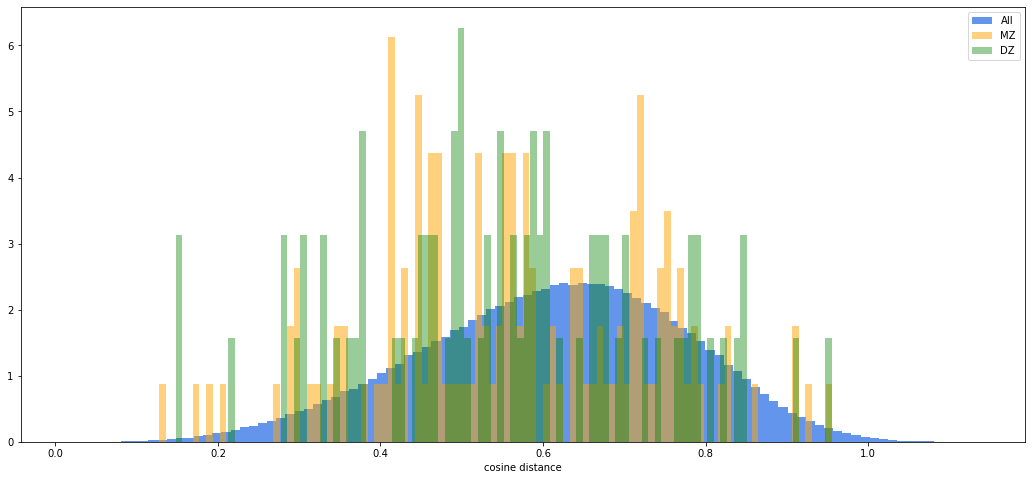

In [21]:
plt.figure(figsize=(18,8))
plt.hist(dist_overall, bins=100, density=True, label='All', color='cornflowerblue')
plt.hist(zygot_dist, bins=100, density=True, alpha=0.5, label='MZ', color='orange')
plt.hist(DZ_dist, bins=100, density=True, alpha=0.4, label='DZ', color='green')
plt.xlabel('cosine distance')
plt.legend()
plt.show()

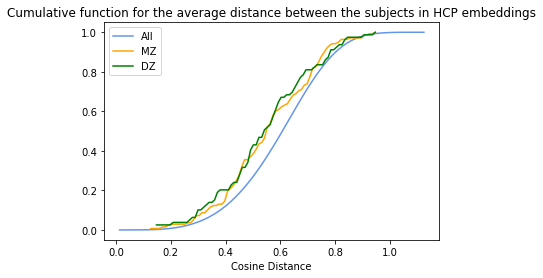

In [22]:
values_all_cos, base_all_cos = np.histogram(dist_overall, bins=80)
cumulative_all = np.cumsum(values_all_cos)
values_MZ, base_MZ_cos = np.histogram(zygot_dist, bins=80)
cumulative_MZ = np.cumsum(values_MZ)
values_DZ, base_DZ = np.histogram(DZ_dist, bins=80)
cumulative_DZ = np.cumsum(values_DZ)
plt.plot(base_all_cos[:-1], cumulative_all/len(dist_overall), c='cornflowerblue', label='All')
plt.plot(base_MZ_cos[:-1], cumulative_MZ/len(zygot_dist), c='orange', label='MZ')
plt.plot(base_DZ[:-1], cumulative_DZ/len(DZ_dist), c='green', label='DZ')
plt.title(f'Cumulative function for the average distance between the subjects in HCP embeddings')
plt.xlabel('Cosine Distance')
plt.legend()
plt.show()

In [23]:
all_cos_dist_mean = dist_overall.sum()/len(dist_overall)
all_cos_dist_mean

0.6121407449259598

In [24]:
all_eucli_dist_mean = eucli_dist_overall.sum()/len(eucli_dist_overall)
all_eucli_dist_mean

134027.5545263499

And compute the relative difference between the average distance and the specific twins' distances. 

In [25]:
(all_cos_dist_mean - zygot_mean_dist)/all_cos_dist_mean

0.07833601317553793

In [26]:
(all_eucli_dist_mean - MZ_mean_eucli_dist)/all_eucli_dist_mean

0.07926365670939702

In [27]:
(all_cos_dist_mean - DZ_mean_cos_dist)/all_cos_dist_mean

0.09524805901744589

In [28]:
(all_eucli_dist_mean - DZ_mean_eucli_dist)/all_eucli_dist_mean

0.09477226730247088

## Definition of a function to compare different embedded spaces for HCP

In [31]:
path_to_save = "/volatile/ad279118/2023_jlaval_STSbabies/contrastive/notebooks/antoine/Heritability/Figures"

In [45]:
def visual_dist_ebd(embedding, metric, title):
    '''
    Parameters
    ----------
    embedding : df
        The dataframe which contains the embedded space
    metric : str
        The distance metric to use

    return
    ------
    Plot the distribution and the cumulative function for all the subjects, 
    the pairs of monozygotic twins and the pairs of dizygotic twins, given
    the sex.
    '''
    sex = [['F'], ['M'], ['F', 'M']]
    name_sex = ['F', 'M', ''] #['F', 'M', 'F & M']

    dic_id = {}

    for i, sexi in enumerate(sex):

        HCP_info_sexi = HCP_info[HCP_info['Gender'].isin(sexi)] # get the df only for 'M' or 'F'
        sexi_id = HCP_info_sexi['Subject'].to_numpy() # get only the id of the subject (for the given sex)
        dist_overall = distance.pdist(embedding.loc[sexi_id].to_numpy(), metric)
        print(f'Average {metric} distance for the all subjects {name_sex[i]} in the {embedding.shape[1]} dim latent space is: {dist_overall.mean()}')

        dic_id[f'{name_sex[i]}_overall_dist'] = dist_overall

        list_siblings_id = []

        for familiy_id in HCP_info_sexi['Family_ID'].unique():
            # we start by checking if there are two siblings (or more) in the same family
            if HCP_info_sexi['Family_ID'].isin([familiy_id]).sum(axis=0) >= 2:
                # get the ID of the siblings that have the same family ID
                siblings = (HCP_info_sexi[HCP_info_sexi['Family_ID'].isin([familiy_id])])
                siblings = siblings[siblings['ZygosityGT'] == ' ']
                if len(siblings) >=2:
                    list_siblings_id.append(siblings['Subject'].to_numpy())

        siblings_dist = []
        for siblings in list_siblings_id:
            siblings_dist.append((distance.pdist(embedding.loc[siblings].to_numpy(), metric))[0])
        
        siblings_mean_dist = np.mean(siblings_dist)

        print(f'Average {metric} distance for the {name_sex[i]} siblings (not twins) in the {embedding.shape[1]} dim latent space is : {siblings_mean_dist}')
        dic_id[f'{name_sex[i]}_siblings_dist'] = siblings_dist

        for zygot in ['MZ', 'DZ']:
            # to get the number of unique family ID
            HCP_info_zygot = HCP_info_sexi[HCP_info_sexi['ZygosityGT'] == zygot]
            # get the twin pairs depending on the family_ID 
            list_zygot_twin_id = []

            for familiy_id in HCP_info_zygot['Family_ID'].unique():
                # we start by checking if there are two twins in the same family
                if HCP_info_zygot['Family_ID'].isin([familiy_id]).sum(axis=0) == 2:
                    # get the ID of the --zygous twins that have the same family ID
                    HCP_target_ID = HCP_info_zygot[HCP_info_zygot['Family_ID'].isin([familiy_id])]
                    list_zygot_twin_id.append(HCP_target_ID['Subject'].to_numpy())

            zygot_dist = []


            for twin_pair in list_zygot_twin_id:
                zygot_dist.append((distance.pdist(embedding.loc[twin_pair].to_numpy(), metric))[0])

            zygot_mean_dist = np.mean(zygot_dist)

            print(f'Average {metric} distance for the {name_sex[i]} {zygot} twin in the {embedding.shape[1]} dim latent space is : {zygot_mean_dist}')
            dic_id[f'{name_sex[i]}_{zygot}_mean_dist'] = zygot_mean_dist
            dic_id[f'{name_sex[i]}_{zygot}_dist'] = zygot_dist

    #plt.figure(figsize=(24,8))
    for i in range(0,3):
        #plt.subplot(2,3,i+1)
        plt.figure(figsize=(12,4))
        plt.hist(dic_id[f'{name_sex[i]}_MZ_dist'], bins=100, density=True, alpha=0.5, label=f'MZ {name_sex[i]}', color='orange')
        plt.hist(dic_id[f'{name_sex[i]}_DZ_dist'], bins=100, density=True, alpha=0.4, label=f'DZ {name_sex[i]}', color='green')
        plt.hist(dic_id[f'{name_sex[i]}_siblings_dist'], bins=100, density=True, alpha=0.4, label=f'Siblings {name_sex[i]}', color='darkorchid')
        plt.hist(dic_id[f'{name_sex[i]}_overall_dist'], bins=100, density=True, label=f'All {name_sex[i]}', color='cornflowerblue')
        plt.xlabel(f'{metric} distance')
        plt.legend()
        plt.savefig(f'{path_to_save}/{metric}_distance_{name_sex[i]}_{title}.eps', format='eps')
        plt.show()

        plt.figure(figsize=(12,4))
        values_all, base_all = np.histogram(dic_id[f'{name_sex[i]}_overall_dist'], bins=80)
        cumulative_all = np.cumsum(values_all)
        values_MZ, base_MZ = np.histogram(dic_id[f'{name_sex[i]}_MZ_dist'], bins=60)
        cumulative_MZ = np.cumsum(values_MZ)
        values_DZ, base_DZ = np.histogram(dic_id[f'{name_sex[i]}_DZ_dist'], bins=60)
        cumulative_DZ = np.cumsum(values_DZ)
        values_siblings, base_siblings = np.histogram(dic_id[f'{name_sex[i]}_siblings_dist'], bins=60)
        cumulative_siblings = np.cumsum(values_siblings)
        #plt.subplot(2,3,i+4)
        plt.plot(base_all[:-1], cumulative_all/len(dic_id[f'{name_sex[i]}_overall_dist']), c='cornflowerblue', label=f'All {name_sex[i]}')
        plt.plot(base_MZ[:-1], cumulative_MZ/len(dic_id[f'{name_sex[i]}_MZ_dist']), c='orange', label=f'MZ {name_sex[i]}')
        plt.plot(base_DZ[:-1], cumulative_DZ/len(dic_id[f'{name_sex[i]}_DZ_dist']), c='green', label=f'DZ {name_sex[i]}')
        plt.plot(base_siblings[:-1], cumulative_siblings/len(dic_id[f'{name_sex[i]}_siblings_dist']), c='darkorchid', label=f'Siblings {name_sex[i]}')
        plt.xlabel(f'Cumulative function for the average distance between the subjects in HCP embeddings')
        plt.legend()
        plt.savefig(f'{path_to_save}/cum_func_{name_sex[i]}_{title}.eps', format='eps')
        plt.show()
        
    #plt.show()

    return dic_id
    

In [70]:
# Embeddings for the CINGULATE region

#embedding = pd.read_csv("/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-13/09-33-29_206/hcp_epoch60_embeddings/full_embeddings.csv", index_col=0)
#embedding = pd.read_csv("/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Input/hcp_cingulate_full_embeddings.csv", index_col=0)
#embedding = pd.read_csv('/neurospin/dico/adufournet/Runs/04_Heritability_Right_PCS_HCP_dim10/Output/2024-05-16/14-59-55_124/HCP_epoch100_embeddings/full_embeddings.csv', index_col=0)
#embedding = pd.read_csv('/neurospin/dico/adufournet/Runs/05_Heritability_Left_PCS_HCP_dim10/Output/2024-05-16/18-00-43_101/HCP_epoch100_embeddings/full_embeddings.csv', index_col=0)

#embedding = pd.read_csv('/neurospin/dico/data/deep_folding/current/models/Champollion_V0/CINGULATE_left/2024-07-16/16-58-04_1/hcp_random_epoch80_embeddings/full_embeddings.csv', index_col=0)
embedding = pd.read_csv('/neurospin/dico/data/deep_folding/current/models/Champollion_V0/CINGULATE_right/09-52-22_75/hcp_random_embeddings/full_embeddings.csv', index_col=0)

In [90]:
# Embeddings for the ORBITAL region

#embedding = pd.read_csv("/neurospin/dico/adufournet/Runs/08_Heritability_Left_Orbital_HCP_dim256/Output/16-19-26_238/HCP_random_epoch50_embeddings/full_embeddings.csv", index_col=0)
#embedding = pd.read_csv("/neurospin/dico/adufournet/Runs/08_Heritability_Left_Orbital_HCP_dim256/Output/20-56-02_0/HCP_random_epoch70_embeddings/full_embeddings.csv", index_col=0)
#embedding = pd.read_csv("/neurospin/dico/adufournet/Runs/08_Heritability_Left_Orbital_HCP_dim256/Output/20-56-02_1/HCP_random_epoch70_embeddings/full_embeddings.csv", index_col=0)
#embedding = pd.read_csv("/neurospin/dico/adufournet/Runs/08_Heritability_Left_Orbital_HCP_dim256/Output/20-56-02_2/HCP_random_epoch70_embeddings/full_embeddings.csv", index_col=0)
#embedding = pd.read_csv("/neurospin/dico/adufournet/Runs/08_Heritability_Left_Orbital_HCP_dim256/Output/20-56-02_3/HCP_random_epoch70_embeddings/full_embeddings.csv", index_col=0)
#embedding = pd.read_csv("/neurospin/dico/adufournet/Runs/08_Heritability_Left_Orbital_HCP_dim256/Output/20-03-01_10/HCP_random_epoch50_embeddings/full_embeddings.csv", index_col=0)

#embedding = pd.read_csv("/neurospin/dico/data/deep_folding/current/models/Champollion_V0/ORBITAL_right/15-53-41_191/hcp_random_embeddings/full_embeddings.csv", index_col=0)

embedding = pd.read_csv('/neurospin/dico/data/deep_folding/current/models/Champollion_V0/ORBITAL_left/20-56-02_1/hcp_random_embeddings/full_embeddings.csv',  index_col=0)


In [91]:
embedding.shape

(1152, 256)

In [92]:
embedding = embedding[~embedding.index.duplicated(keep='first')]

In [84]:
embedding.shape

(1113, 256)

Average cosine distance for the all subjects F in the 256 dim latent space is: 0.6161066370766455
Average cosine distance for the F siblings (not twins) in the 256 dim latent space is : 0.5455125222591325
Average cosine distance for the F MZ twin in the 256 dim latent space is : 0.49381022175951983
Average cosine distance for the F DZ twin in the 256 dim latent space is : 0.5567745567044342
Average cosine distance for the all subjects M in the 256 dim latent space is: 0.5980291922046281
Average cosine distance for the M siblings (not twins) in the 256 dim latent space is : 0.5516072319487108
Average cosine distance for the M MZ twin in the 256 dim latent space is : 0.47616248836356445
Average cosine distance for the M DZ twin in the 256 dim latent space is : 0.5808540390953366
Average cosine distance for the all subjects  in the 256 dim latent space is: 0.612675974343048
Average cosine distance for the  siblings (not twins) in the 256 dim latent space is : 0.5404010441284065
Average co

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


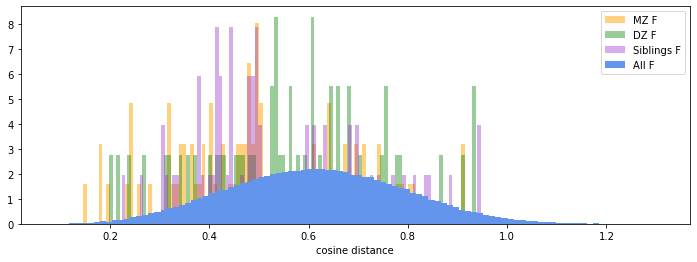

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


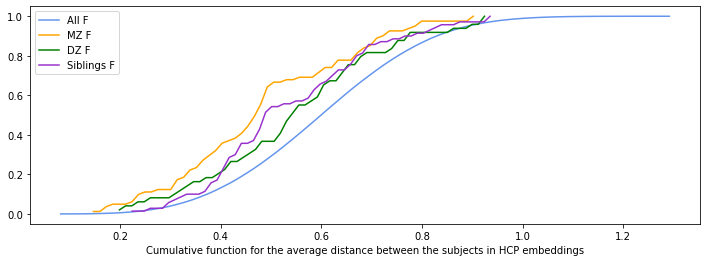

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


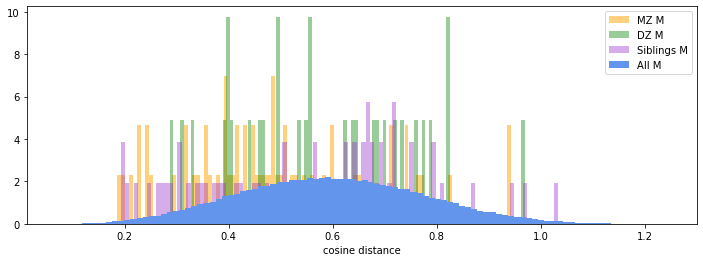

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


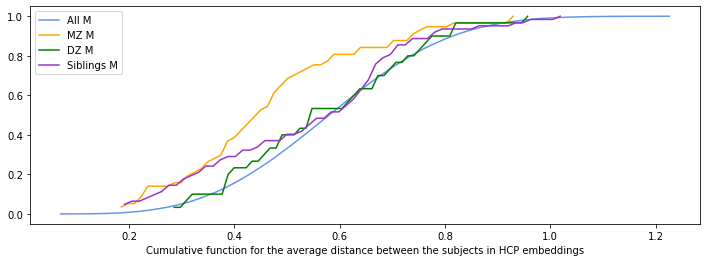

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


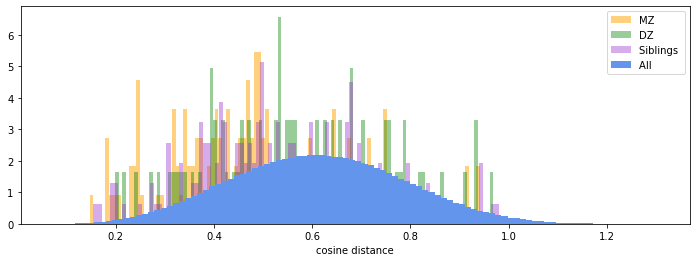

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


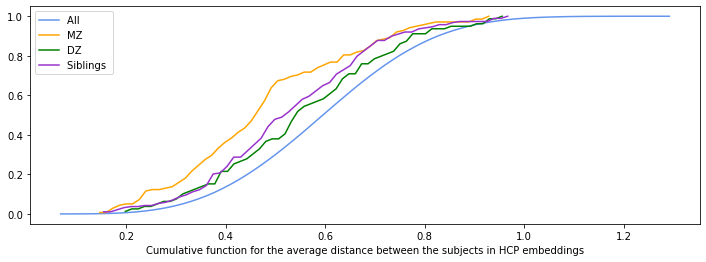

In [93]:
dic_rslt = visual_dist_ebd(embedding, 'cosine', 'Left_ORBITAL')# 'chebyshev', 'euclidean', 'cosine'

### Test et p-value

In [94]:
dic_rslt.keys()

dict_keys(['F_overall_dist', 'F_siblings_dist', 'F_MZ_mean_dist', 'F_MZ_dist', 'F_DZ_mean_dist', 'F_DZ_dist', 'M_overall_dist', 'M_siblings_dist', 'M_MZ_mean_dist', 'M_MZ_dist', 'M_DZ_mean_dist', 'M_DZ_dist', '_overall_dist', '_siblings_dist', '_MZ_mean_dist', '_MZ_dist', '_DZ_mean_dist', '_DZ_dist'])

In [95]:
len(dic_rslt['_overall_dist'])
len(dic_rslt['_siblings_dist'])
len(dic_rslt['_MZ_dist'])
len(dic_rslt['_DZ_dist'])

79

In [96]:
from scipy.stats import kruskal

/tmp/ipykernel_3056041/2463523939.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Category', y='Distance', data=df, order=labels, palette=[colors[label] for label in labels])


p-value between ('overall', 'siblings'): 2.418918496059239e-08
p-value between ('overall', 'MZ'): 8.538410396395282e-16
p-value between ('overall', 'DZ'): 0.023393787059651797


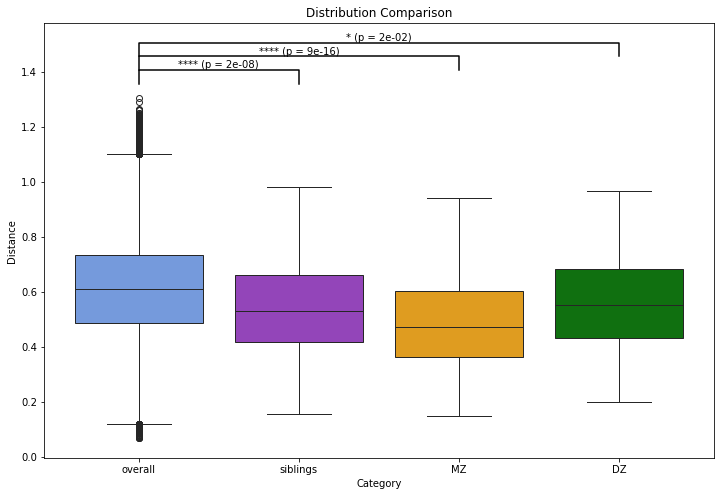

In [97]:

# Convert data to a DataFrame for use with Seaborn
data = []
labels = ['overall', 'siblings', 'MZ', 'DZ']

for label in labels:
    data.extend([(label, value) for value in dic_rslt[f'_{label}_dist']])

df = pd.DataFrame(data, columns=['Category', 'Distance'])

colors = {
    'overall': 'cornflowerblue',
    'siblings': 'darkorchid',
    'MZ': 'orange',
    'DZ': 'green'
}

# Create the boxplot
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='Category', y='Distance', data=df, order=labels, palette=[colors[label] for label in labels])

# Define the box pairs for comparison
box_pairs = [
    ("overall", "siblings"),
    ("overall", "MZ"),
    ("overall", "DZ")
]

# Perform the Kruskal-Wallis H-test for each pair and add annotations
max_value = df['Distance'].max()
h = 0.05
y_offset = max_value + h

for (cat1, cat2) in box_pairs:
    data1 = df[df['Category'] == cat1]['Distance']
    data2 = df[df['Category'] == cat2]['Distance']
    
    stat, p = kruskal(data1, data2)
    print(f"p-value between {(cat1, cat2)}: {p}")
    
    # Define the position for the annotations
    x1, x2 = labels.index(cat1), labels.index(cat2)
    y, col = y_offset, 'k'
    
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    if p > 0.05:
        significance = "ns"
    elif p > 0.01:
        significance = "*"
    elif p > 0.001:
        significance = "**"
    elif p > 0.0001:
        significance = "***"
    else:
        significance = "****"

    # Round the p-value to 3 significant digits for display
    rounded_p = f"{p:.0e}"
    
    # Concatenate significance and p-value
    annotation = f"{significance} (p = {rounded_p})"
    
    plt.text((x1 + x2) * .5, y + h, annotation, ha='center', va='bottom', color=col)
    
    y_offset += h  # Increment y position for the next bracket

# Add legend for p-value annotations
"""legend_text = (
    "ns: 5e-2 < p <= 1\n"
    "*: 1e-2 < p <= 5e-2\n"
    "**: 1e-3 < p <= 1e-2\n"
    "***: 1e-4 < p <= 1e-3\n"
    "****: p <= 1e-04"
)
plt.gcf().text(0.75, 0.9, legend_text, fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))"""

plt.title('Distribution Comparison')
plt.ylabel('Distance')
plt.savefig(f'{path_to_save}/boxplot_LEFT_ORBITAL.eps', format='eps')
plt.show()

In [331]:
len(dic_rslt['F & M_MZ_dist']), len(dic_rslt['F & M_DZ_dist'])    

(138, 79)

In [333]:
from tqdm import tqdm
from random import sample

def Monte_Carlo_p_value(embedding, list_dist, metric, rep=1e5):
    '''
    Parameters
    ----------
    embedding : df
        The dataframe which contains the embedded space
    list_dist : list
        The list which contains the distances for differents pairs of subjects
    metric : str
        The distance metric to use

    return
    ------
    p : float
        The probability of having a sample of points of the same size as the given 
        list_dist whose average distance is below the average distance of
        list_dist
    '''
    k=0
    for i in tqdm(range(int(rep))):

        embedding_sample = embedding.sample(n=2*len(list_dist))
        dist = []

        for j in range(len(list_dist)):
            id = sample([o for o in range(len(embedding_sample))], 2)
            dist.append(distance.pdist(embedding_sample.iloc[id,:].to_numpy(), metric))
            embedding_sample = embedding_sample.drop(embedding_sample.iloc[id,:].index, axis=0)

        if np.mean(dist) <= np.mean(list_dist):
            k+=1
    
    return k/rep

In [334]:
from p_tqdm import p_map

'''
Batch Processing: The simulations are processed in batches to reduce the overhead associated with parallel task management.
Efficient Data Handling: The large embedding DataFrame is not duplicated unnecessarily.
'''

class MonteCarloSimulation:
    def __init__(self, embedding, list_dist, metric='cosine', rep=int(1e6), batch_size=100):
        self.embedding = embedding
        self.list_dist = list_dist
        self.metric = metric
        self.rep = rep
        self.batch_size = batch_size

    def is_mean_pair_dist_below(self, batch_rep):
        results = []
        for _ in range(batch_rep):
            embedding_sample = self.embedding.sample(n=2 * len(self.list_dist))
            dist = []

            for j in range(len(self.list_dist)):
                ids = sample([o for o in range(len(embedding_sample))], 2)
                dist.append(distance.pdist(embedding_sample.iloc[ids, :].to_numpy(), self.metric))
                embedding_sample = embedding_sample.drop(embedding_sample.index[ids])

            results.append(np.mean(dist) <= np.mean(self.list_dist))
        return results

    def compute_p_value(self):
        batch_reps = [self.batch_size] * (self.rep // self.batch_size) + [self.rep % self.batch_size]
        results = p_map(self.is_mean_pair_dist_below, batch_reps, num_cpus=40)
        flattened_results = [item for sublist in results for item in sublist]
        return np.mean(flattened_results)

Test the function with a list of two floats, which are just below the average distance for this specific embedding with the distance cosine.
The expected output is 0.5, because half of the random samples must have an average distance below it.

In [335]:
simulation = MonteCarloSimulation(embedding,[dic_rslt['F & M_overall_dist'].mean(),dic_rslt['F & M_overall_dist'].mean()], 'cosine', int(1e5), 100)

In [336]:
simulation.compute_p_value()

  0%|          | 0/1001 [00:00<?, ?it/s]

0.49198

Let's see the probability to get a sample with an average distance below the average distance for both F and M monozygous twin.

In [ ]:
Monte_Carlo_p_value(embedding, dic_rslt['F & M_MZ_dist'], 'cosine')

100%|██████████| 100000/100000 [1:54:33<00:00, 14.55it/s]


1e-05

In [341]:
simulation = MonteCarloSimulation(embedding,dic_rslt['F & M_MZ_dist'], 'cosine', rep=int(1e5), batch_size=60)

In [342]:
simulation.compute_p_value()

  0%|          | 0/1667 [00:00<?, ?it/s]

0.00151

In [339]:
simulation = MonteCarloSimulation(embedding, dic_rslt['F & M_DZ_dist'], 'cosine', rep=int(1e5), batch_size=60)

In [340]:
simulation.compute_p_value()

  0%|          | 0/1667 [00:00<?, ?it/s]

0.00062